## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

captions.txt  images  test_captions.txt  train_captions.txt
There are 50 image to captions


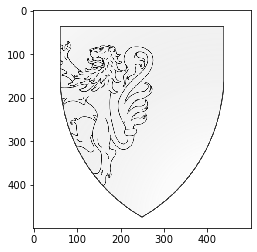

Caption: image_12.png
Caption: image_13.png
Caption: image_14.png
Caption: image_15.png
Caption: image_16.png


In [21]:
#location of the data 
data_location =  '/home/space/datasets/COA/generated-data-api-smaller'
# data_location =  'generated-data-api'
!ls $data_location

#reading the text data 

caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)



#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location + '/images/'+ df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:", df.iloc[i,0])


# Split Data into Training/Test datasets 

In [22]:
train_annotation_file = data_location + '/train_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

# Comment out to keep those for later to compare different models 


# train=df.sample(frac=0.8,random_state=200) #random state is a seed value
# test=df.drop(train.index)

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)


In [23]:
#imports 
import os
import torch
import spacy
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from time import sleep


from src.baseline.vocabulary import Vocabulary
from src.baseline.coa_dataset import CoADataset
from src.baseline.caps_collate import CapsCollate
from src.baseline.data_loader import get_loader

torch.cuda.empty_cache()


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-12GB'

# Image Captioning With Attention - Pytorch

In [26]:
#show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def print_time(text):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("{} @ Time = {}".format(text, current_time))


In [28]:
#Initiate the Dataset and Dataloader

#setting the constants
# BATCH_SIZE = 256
BATCH_SIZE = 5
NUM_WORKER = 2
freq_threshold = 5
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}
        
#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

print_time('writing the dataloader')

train_loader, test_loader, train_dataset, test_dataset = get_loader(
    root_folder=data_location+"/images",
    train_annotation_file=data_location+"/train_captions.txt",
    test_annotation_file=data_location+"/test_captions.txt",
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE
)

print_time('finished writing the dataloader')

# batch size = 10 
# writing the dataloader @ Time = 17:11:37
# finished writing the dataloader @ Time = 17:42:28


# batch size = 1024 & no build-vocab = no time at all



writing the dataloader @ Time = 15:32:04
vocab is passed
vocab is passed
finished writing the dataloader @ Time = 15:32:04


In [29]:
len(train_loader), len(test_loader), len(train_dataset), len(test_dataset)

(8, 2, 40, 10)

In [30]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'g': 4,
 'v': 5,
 'b': 6,
 'cross': 7,
 'lion': 8,
 'passt': 9,
 's': 10,
 'a': 11,
 'eagle': 12,
 'o': 13,
 'doubleheaded': 14,
 "'s": 15,
 'head': 16,
 'patonce': 17,
 'moline': 18,
 'guard': 19,
 'rampant': 20}

In [31]:
train_dataset.vocab.itos

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: 'g',
 5: 'v',
 6: 'b',
 7: 'cross',
 8: 'lion',
 9: 'passt',
 10: 's',
 11: 'a',
 12: 'eagle',
 13: 'o',
 14: 'doubleheaded',
 15: "'s",
 16: 'head',
 17: 'patonce',
 18: 'moline',
 19: 'guard',
 20: 'rampant'}

### Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

In [32]:
import torch
import nltk
import numpy as np
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
from src.baseline.model import EncoderCNN, Attention, DecoderRNN, EncoderDecoder


In [33]:

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for idx, (images, correct_captions) in enumerate(iter(test_loader)):
            print('idx', idx)
            features = model.encoder(images.to(device))
            for i in range(features.shape[0]):
                images, labels = data
                # run the model on the test set to predict labels
                caps, alphas = model.decoder.generate_caption(features[i:i+1], vocab=train_dataset.vocab)
                caps = caps[:-1]
                caption = ' '.join(caps)
                correct_caption = []
                
                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()
                
                print('accuracy: ', accuracy)
                print('---------------------')

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print('Final accuracy: ', accuracy)
    return(accuracy)


def test_function(model, test_loader):
    model.eval()
    bleu_score = 0
    for idx, (images, correct_captions) in enumerate(iter(test_loader)):
        features = model.encoder(images.to(device))
        for i in range(features.shape[0]):
            caps, alphas = model.decoder.generate_caption(features[i:i+1], vocab=train_dataset.vocab)
            caps = caps[:-1]
            caption = ' '.join(caps)
            correct_caption = []
            for j in correct_captions[i:i+1][0]:
                if j.T.item() not in [0, 1, 2]:
                    correct_caption.append(test_dataset.vocab.itos[j.item()])
                    
            bleu = nltk.translate.bleu_score.sentence_bleu([correct_caption], caps, weights=(0.5, 0.5))
            correct_caption = ' '.join(correct_caption)
            write_this = correct_caption + ', ' + caption + '\n'
            bleu_score += bleu
            
    return bleu_score/8091



In [34]:
#helper function to save the model
def save_model(model, optimizer, epoch, model_full_path):
    model_state = {
        'epoch': epoch,
        'embed_size': embed_size,
        'vocab_size': len(train_dataset.vocab),
        'attention_dim': attention_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
        'state_dict': model.state_dict(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(model_state, model_full_path)
    

def get_new_model():
    model = EncoderDecoder(embed_size, len(train_dataset.vocab), attention_dim, encoder_dim, decoder_dim, drop_prob=0.3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

    return model, optimizer, criterion


def load_model(model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model, _, _ = get_new_model()
    
    model.load_state_dict(torch.load(model_path))

    return model

def load_model_checkpoint(model_path):
    checkpoint = torch.load(model_path)
    
    model, optimizer, criterion = get_new_model()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss



### Setting Hypperparameter and Init the model

In [35]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [17]:
# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# model = load_trained_model(model_path)

In [37]:
#initialize new model, loss etc
model, optimizer, criterion = get_new_model()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.91 GiB total capacity; 153.01 MiB already allocated; 4.25 MiB free; 162.00 MiB reserved in total by PyTorch)

## Training Job from above configs

In [19]:
# model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_state-smalll-mon.pth'
# model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.91 GiB total capacity; 150.42 MiB already allocated; 6.25 MiB free; 160.00 MiB reserved in total by PyTorch)

In [94]:
num_epochs = 20
print_every = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if model is None:
    

for epoch in range(1, num_epochs + 1): 
    if model is None:
        model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)

    with tqdm(train_loader, unit="batch") as tepoch:
         for image, captions in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            image, captions = image.to(device), captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()
            # Feed forward
            outputs, attentions = model(image, captions.T)
            # Calculate the batch loss.
            targets = captions.T[:,1:]  ####### the fix in here
            
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            # Backward pass. 
            loss.backward()
            # Update the parameters in the optimizer.
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)

    print(test_function(model, test_loader))
    
    #save the latest model
    save_model(model, optimizer, epoch, model_full_path)

Epoch 1:  50%|███████████████               | 4/8 [00:03<00:02,  1.62batch/s, loss=1.25]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14608934dee0>
Traceback (most recent call last):
  File "/home/salnabulsi/.thesis-py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/salnabulsi/.thesis-py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14608934dee0>
Traceback (most recent call last):
  File "/home/salnabulsi/.thesis-py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():    self._shutdown_workers()

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
      File "/home/salnabulsi/.thesis-py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_worke

3.9296018823485215e-05


Epoch 2:  38%|███████████▎                  | 3/8 [00:03<00:05,  1.02s/batch, loss=1.05]


KeyboardInterrupt: 

In [33]:
torch.cuda.empty_cache()


In [34]:

model.eval()
bleu_score = 0
f = open("results.txt", "w")
for idx, (images, correct_captions) in enumerate(iter(test_loader)):
    print(idx)
    features = model.encoder(images.to(device))
    for i in range(features.shape[0]):
        caps, alphas = model.decoder.generate_caption(features[i:i+1], vocab=train_dataset.vocab)
        caps = caps[:-1]
        caption = ' '.join(caps)
        correct_caption = []
        for j in correct_captions.T[i:i+1][0]:
            if j.item() not in [0, 1, 2]:
                correct_caption.append(test_dataset.vocab.itos[j.item()])
        bleu = nltk.translate.bleu_score.sentence_bleu([correct_caption], caps, weights=(0.5, 0.5))
        correct_caption = ' '.join(correct_caption)
        write_this = correct_caption + ', ' + caption + '\n'
        bleu_score += bleu
        f.write(write_this)
f.close()
print(bleu_score/8091)


0
1
2
3


KeyboardInterrupt: 

##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [49]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)
    


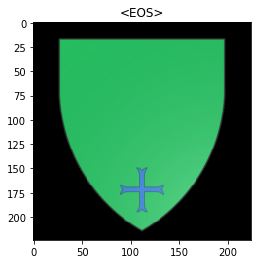

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 1080x1080 with 0 Axes>

In [50]:
# torch.cuda.empty_cache()

model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
model = load_trained_model(model_path)
test_rand_image(model)